In [1]:
import math

from portfolio import Portfolio
from backtest import Backtest
from strategies import *
from config import *
from utils import plot_distribution, PolygonAPI
from data_processing import *

In [2]:
# get SPY data
spy_df = get_spy_data(start_date, end_date)
print("Number of days to backtest: ", len(spy_df))
spy_df.head(5)

Number of days to backtest:  390


,Date,Open,High,Low,Close,Adj Close,Volume
5514,2022-12-01,408.769989,410.000000,404.750000,407.380005,396.928986,76398200
5515,2022-12-02,402.250000,407.859985,402.140015,406.910004,396.471039,85342700
5516,2022-12-05,403.950012,404.929993,398.170013,399.589996,389.338928,77289800
5517,2022-12-06,399.420013,399.989990,391.640015,393.829987,383.726593,77972200
5518,2022-12-07,392.940002,395.640015,391.970001,393.160004,383.073822,65927900


In [3]:
# instantiation
my_portfolio = Portfolio(initial_portfolio_nominal_value, portolio_weights_config, collateral_ratio)
my_strategy = ZeroCostCollar0DTE(my_portfolio, 'SPY', spy_df)
env = Backtest(my_portfolio, spy_df, PolygonAPI(api_key='MPkBRXXyfleZXSJQp8_bOsKuqo2Wi_Gk'))

# If option price data is not available on Polygon.io at any point, the BS Model will be used to calculate price. 
# In such cases, the system will print relevant information.
if strategy_selected == 1:
    env.get_option_price('SPY', bs_config, open_price_config, zero_cost_search_config)
    my_strategy.find_zero_cost_collar(env)
elif strategy_selected == 2:
    my_strategy.select_options(env, strike_selection_config)
    env.get_option_price('SPY', bs_config, open_price_config)
else:
    raise ValueError("Check config, strategy does not exist. ")

env.update_option_price_at_expiration()
my_strategy.update_collar_pnl(env.main_df)

Fetching option prices using multithreading: 100%|██████████| 4314/4314 [01:30<00:00, 47.58it/s]


BS model is not used. All prices are sourced from Polygon.io.


In [4]:
# Buy and hold SPY at market open on Day 1
first_date = env.main_df['Date'].values[0]
first_price = env.main_df['Open'].values[0]

target_spy_exposure = my_portfolio.initial_portfolio_nominal_value * my_portfolio.target_portfolio_weights['equity']
n_spy_to_buy = math.floor(target_spy_exposure / first_price)
my_strategy.execute_buy_and_hold_underlying('equity', first_date, first_price, n_spy_to_buy)

print('Portfolio position:', my_portfolio.positions)
print('Cash after buying SPY:', my_portfolio.cash)
print('Transaction history')
my_portfolio.print_transaction_history()

Portfolio position: {'equity': {'SPY': 1957}}
Cash after buying SPY: 200037.13
Transaction history
2022-12-01: ['bought 1957 SPY at 408.77 on 2022-12-01.']


In [5]:
# Run the zero-cost collar strategy every day in spy_df
# If an error occurs during env.run() due to insufficient cash, the following plots can still be generated.
env.run(my_strategy)


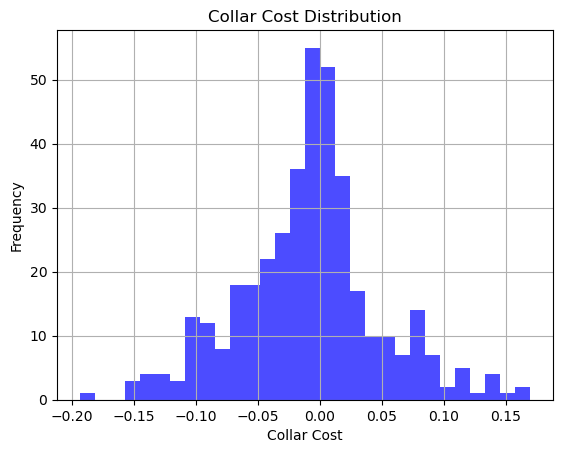

In [6]:
# Plot the distribution of collar strategy cost. Negative cost means the call premium is larger than put premium (i.e. receiving a credit to open)
plot_distribution(env.main_df['collar_cost'], x_label='Collar Cost', title='Collar Cost Distribution')

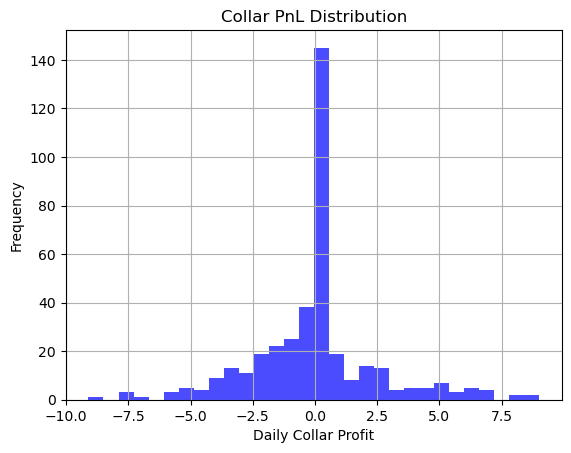

In [7]:
# Plot the distribution collar strategy PnL
plot_distribution(env.main_df['collar_pnl'], x_label='Daily Collar Profit', title='Collar PnL Distribution')

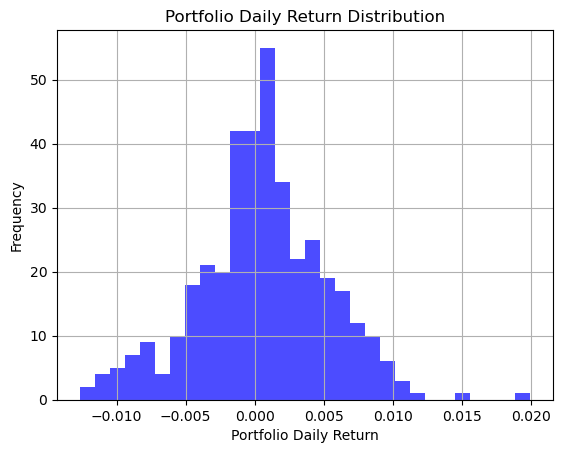

In [8]:
port_return = my_portfolio.calc_port_daily_return()
plot_distribution(port_return, x_label='Portfolio Daily Return', title='Portfolio Daily Return Distribution')

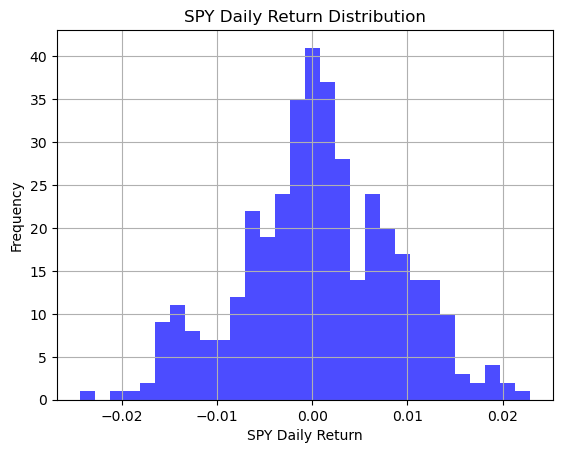

In [9]:
spy_return = env.calc_benchmark_return()
plot_distribution(spy_return, x_label='SPY Daily Return', title='SPY Daily Return Distribution')

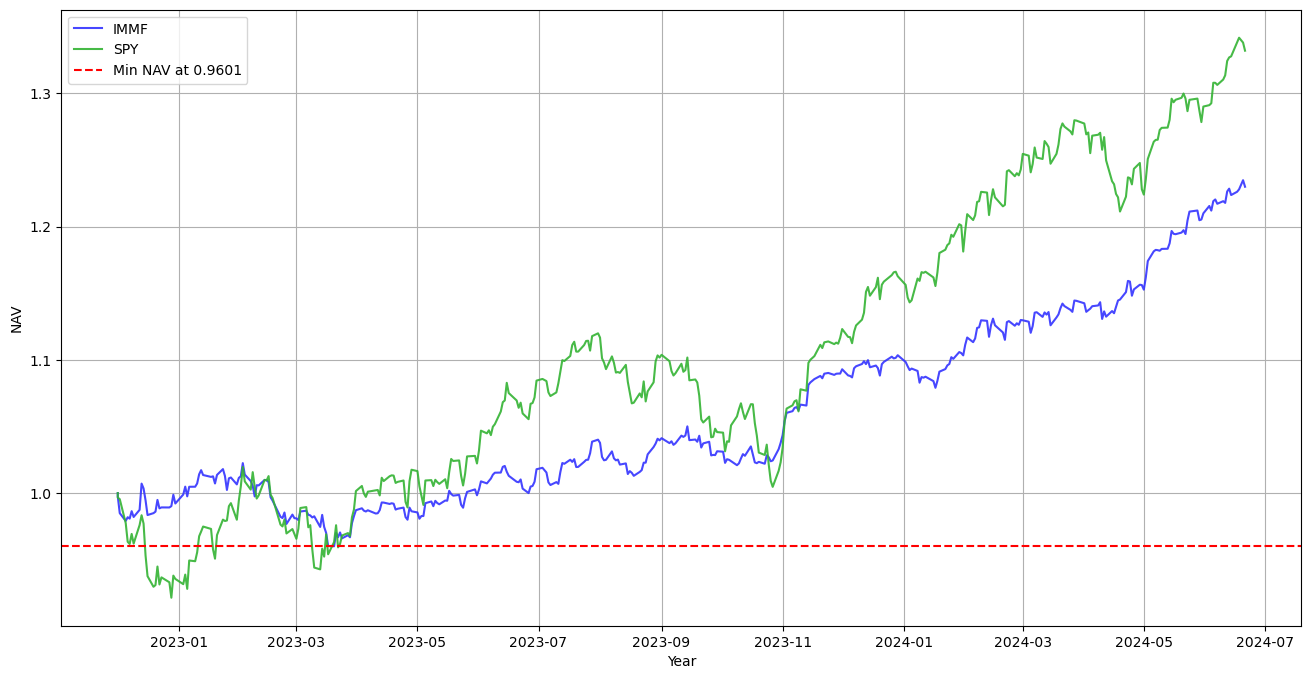

In [10]:
env.plot_nav_vs_spy()

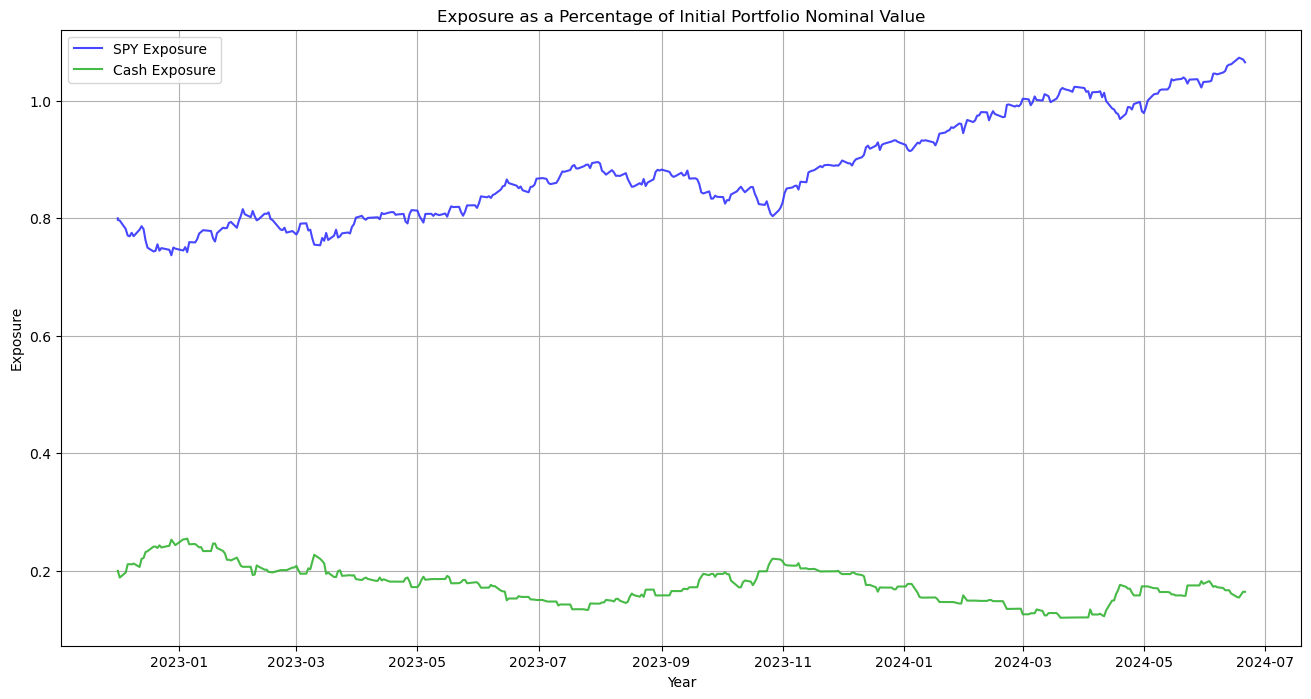

In [11]:
env.plot_exposure()

In [12]:
# Optional commands which could be useful for further review and analysis.

# Save the backtest main dataframe to the data folder
# env.save_main_df_to_csv()

# Save transaction history to the data folder
# my_portfolio.save_transaction_history_to_csv()

# Print all transaction history in the backtest
# my_portfolio.print_transaction_history()

# Print portfolio attributes
# print(my_portfolio.positions, my_portfolio.cash, my_portfolio.margin)
